# Baseline with Histogram Equalization Technique
This notebook serves to estimate possible effectiveness of a Light Schrödinger Bridge technique and the possible ineffectiveness of simple brightness/contrast enhancing techniques, for instance, histogram equalization and the more sophisticated version CLAHE. 

## Imports

In [1]:
import os, sys

# if colab, mount drive and get the git repo
if 'google.colab' in sys.modules:
    from google.colab import drive
    print(os.getcwd())
    drive.mount('/content/drive')
    !git clone --recurse-submodules https://github.com/jsluijter02/LightSB_YOLO

    # Append LightSB_YOLO path
    sys.path.append(os.path.join(os.getcwd(), 'LightSB_YOLO'))

# otherwise local path append
else:
    sys.path.append(os.path.dirname(os.getcwd()))

In [14]:
from scripts.utils import dirs
dirs.add_YOLOPX_to_PATH()

import torchvision.transforms as transforms
import pickle as pkl
import copy
from argparse import Namespace
from tqdm import tqdm

import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from scripts.models.yolo import YOLOPX_BDD
from scripts.dataset import bdd
from scripts.utils import img 

np.random.seed(0)

## YOLO Model Initialization

In [3]:
model = YOLOPX_BDD()

AUTO_RESUME: False
CUDNN:
  BENCHMARK: True
  DETERMINISTIC: False
  ENABLED: True
DATASET:
  CLAHE_CLIPLIMIT: 2.0
  CLAHE_VAL: False
  COLOR_RGB: False
  DATAROOT: /Users/jochem/Documents/GitHub/LightSB_YOLO/data/bdd/images
  DATASET: BddDataset
  DATA_FORMAT: jpg
  FLIP: True
  HSV_H: 0.015
  HSV_S: 0.7
  HSV_V: 0.4
  LABELROOT: /Users/jochem/Documents/GitHub/LightSB_YOLO/data/bdd/det_annotations
  LANEROOT: /Users/jochem/Documents/GitHub/LightSB_YOLO/data/bdd/ll_seg_annotations
  MASKROOT: /Users/jochem/Documents/GitHub/LightSB_YOLO/data/bdd/da_seg_annotations
  ORG_IMG_SIZE: [720, 1280]
  ROT_FACTOR: 10
  SCALE_FACTOR: 0.25
  SELECT_DATA: False
  SHEAR: 0.0
  TEST_SET: val
  TRAIN_SET: train
  TRANSLATE: 0.1
DEBUG: False
GPUS: (0,)
LOG_DIR: runs/
LOSS:
  BOX_GAIN: 0.05
  CLS_GAIN: 0.5
  CLS_POS_WEIGHT: 1.0
  DA_SEG_GAIN: 0.2
  FL_GAMMA: 2.0
  LL_IOU_GAIN: 0.2
  LL_SEG_GAIN: 0.2
  LOSS_NAME: 
  MULTI_HEAD_LAMBDA: None
  OBJ_GAIN: 1.0
  OBJ_POS_WEIGHT: 1.0
  SEG_POS_WEIGHT: 1.0
MODEL

=> creating runs/BddDataset/_2026-01-23-21-40


/Users/jochem/Documents/GitHub/LightSB_YOLO/scripts/models/yolo.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.weights, map_location=self.

## Sample Night Set Images

In [4]:
train_night_db = bdd.get_db(model.config, is_train=True, timeofday="night")

sample_indices = img.sample_indices(len(train_night_db), how_many=3)
print("sample indices: ", sample_indices)

sample indices:  [11010 26205 17150]


/opt/anaconda3/envs/lightsb_yolo/lib/python3.8/site-packages/albumentations/core/composition.py:192: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


## HSV Image Histogram

<Figure size 640x480 with 0 Axes>

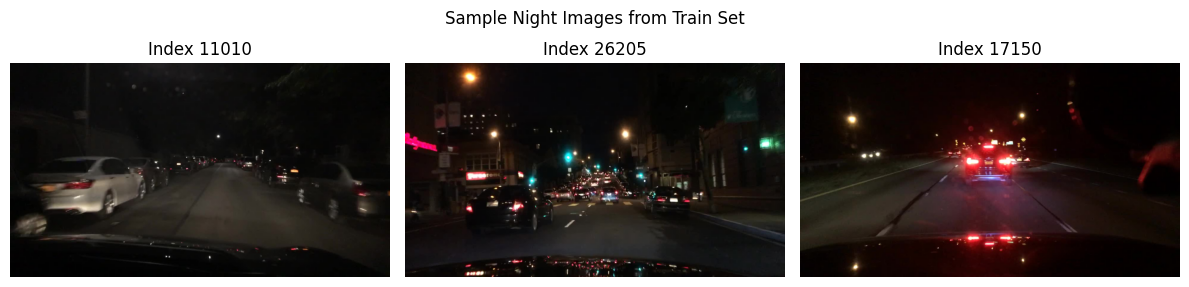

<Figure size 640x480 with 0 Axes>

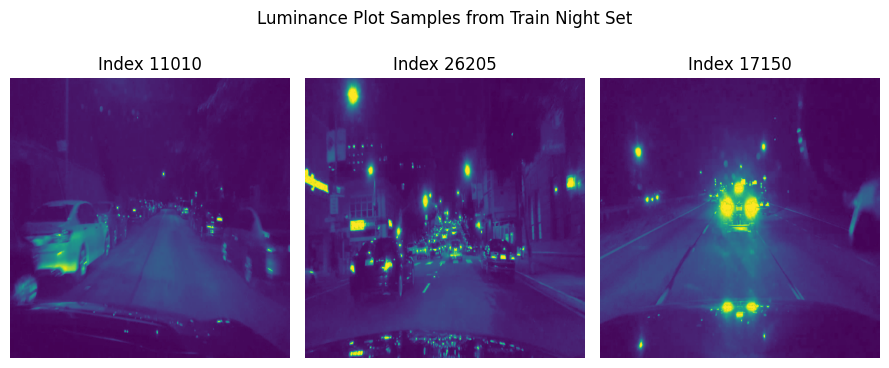

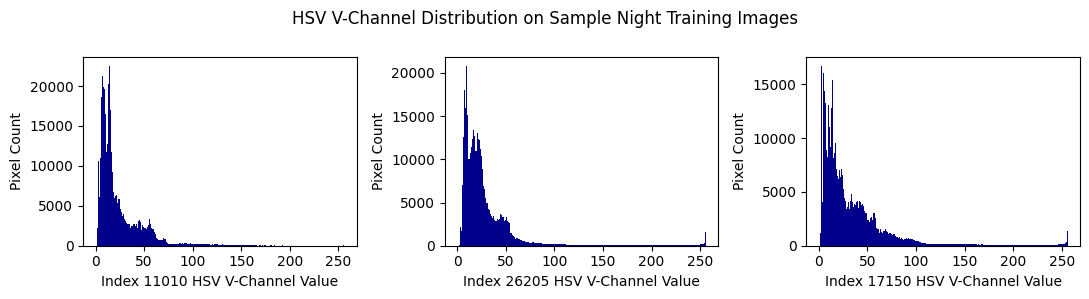

In [5]:
# arbitrary night image
RGB_imgs = []
HSV_imgs= []
for index in sample_indices:
    night_img_path = train_night_db[index]['image']
    night_img = cv2.imread(night_img_path)
    RGB_imgs.append(cv2.cvtColor(night_img, cv2.COLOR_BGR2RGB))

    night_img_resized = cv2.resize(night_img, (640,640))
    night_img_hsv = cv2.cvtColor(night_img_resized, cv2.COLOR_BGR2HSV)
    HSV_imgs.append(night_img_hsv)

# img
plt.figure()
img.plot_samples(RGB_imgs, "Sample Night Images from Train Set", 
                 labels=[f"Index {i}" for i in sample_indices], square=False)
plt.show()

plt.figure()
img.plot_samples([HSV_img[:,:,2] for HSV_img in HSV_imgs], 
                 title="Luminance Plot Samples from Train Night Set", 
                 labels= [f'Index {index}' for index in sample_indices])
plt.show()

## now plot the value (brightness levels) accross this night image
plt.figure(figsize=(11,3))
for i, image in enumerate(HSV_imgs):
    plt.subplot(1,3,i+1)
    plt.hist(image[:,:,2].ravel(),256,[0,256], color="darkblue")
    plt.ylabel("Pixel Count")
    plt.xlabel(f"Index {sample_indices[i]} HSV V-Channel Value")
plt.suptitle("HSV V-Channel Distribution on Sample Night Training Images")
plt.tight_layout()
plt.show()

## Regular Histogram Equalization

<Figure size 640x480 with 0 Axes>

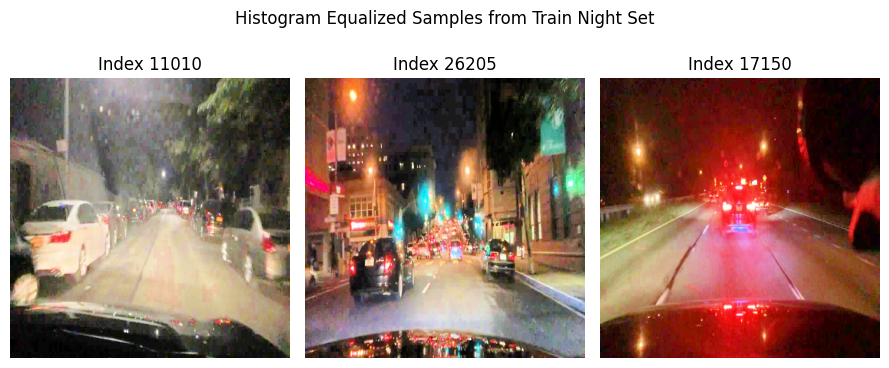

<Figure size 640x480 with 0 Axes>

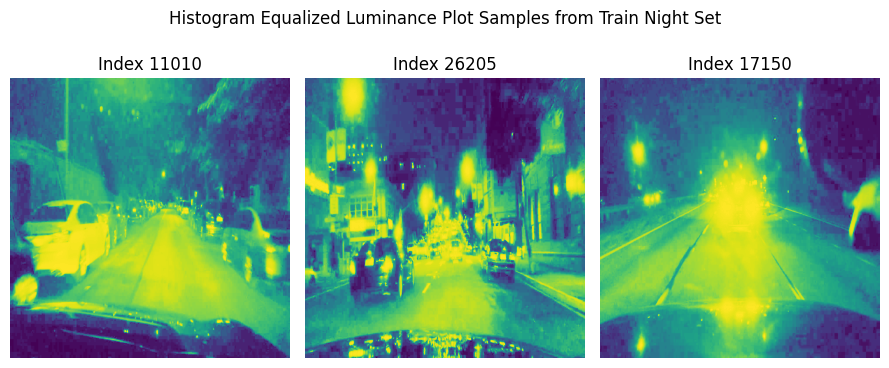

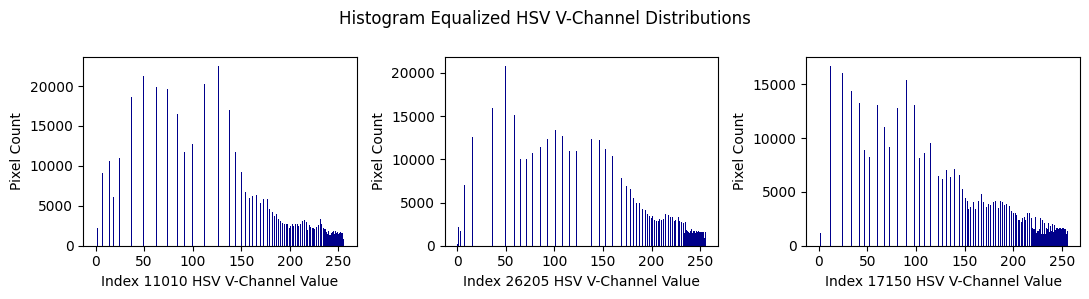

In [6]:
# source: https://www.geeksforgeeks.org/python/histograms-equalization-opencv/
# HISTOGRAM EQ
HE_imgs = []
for image in HSV_imgs:
    night_img_HE = copy.copy(image)
    night_img_HE[:,:,2] = cv2.equalizeHist(night_img_HE[:,:,2])
    HE_imgs.append(night_img_HE)

plt.figure()
img.plot_samples([cv2.cvtColor(HE_img, cv2.COLOR_HSV2RGB) for HE_img in HE_imgs], 
                 title= "Histogram Equalized Samples from Train Night Set", 
                 labels= [f'Index {index}' for index in sample_indices])
plt.show()
plt.figure()
img.plot_samples([HE_img[:,:,2] for HE_img in HE_imgs], 
                 title="Histogram Equalized Luminance Plot Samples from Train Night Set", 
                 labels= [f'Index {index}' for index in sample_indices])
plt.show()

# new hist plot
plt.figure(figsize=(11,3))
for i, image in enumerate(HE_imgs):
    plt.subplot(1,3,i+1)
    plt.hist(image[:,:,2].ravel(),256,[0,256], color="darkblue")
    plt.ylabel("Pixel Count")
    plt.xlabel(f"Index {sample_indices[i]} HSV V-Channel Value")
plt.suptitle("Histogram Equalized HSV V-Channel Distributions")
plt.tight_layout()
plt.show()

## CLAHE Histogram

<Figure size 640x480 with 0 Axes>

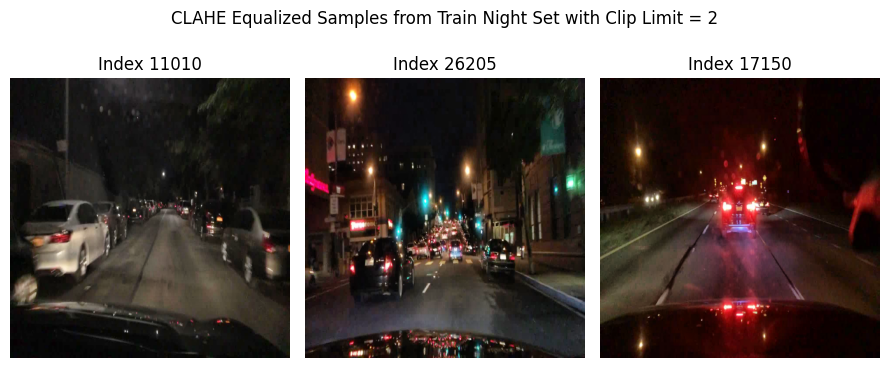

<Figure size 640x480 with 0 Axes>

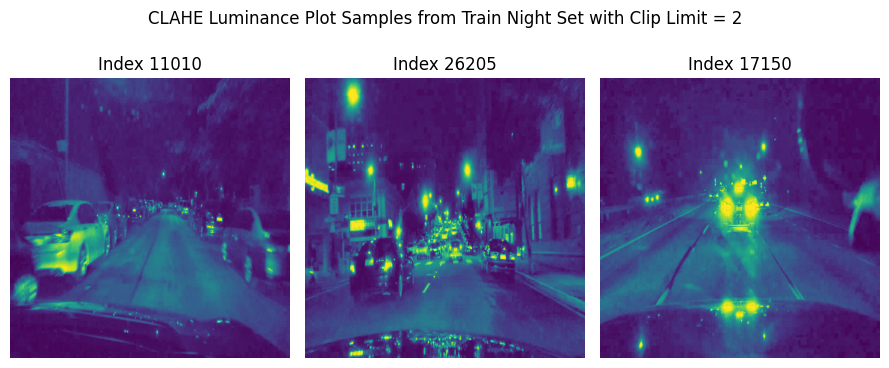

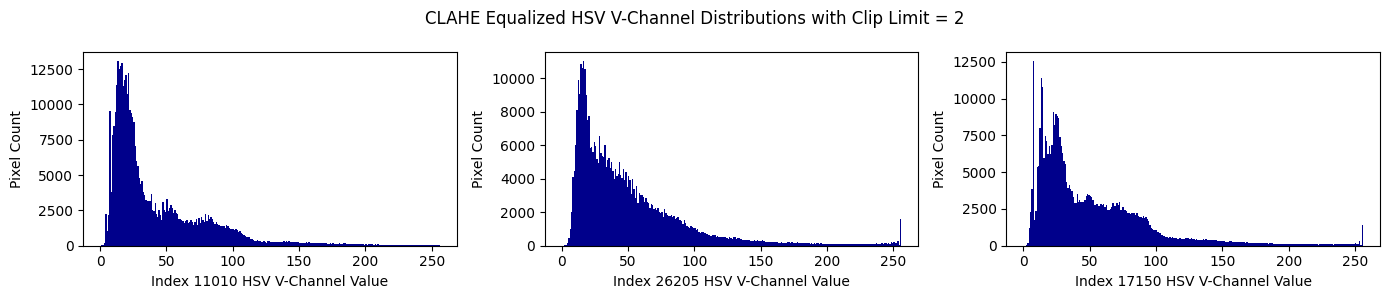

In [7]:
clahe = cv2.createCLAHE(clipLimit=2)
CLAHE_imgs = []
for image in HSV_imgs:
    night_img_CLAHE = copy.copy(image)
    night_img_CLAHE[:,:,2] = np.clip(clahe.apply(night_img_CLAHE[:,:,2]), 0, 255).astype(np.uint8)
    CLAHE_imgs.append(night_img_CLAHE)

plt.figure()
img.plot_samples([cv2.cvtColor(CLAHE_img, cv2.COLOR_HSV2RGB) for CLAHE_img in CLAHE_imgs], 
                 title= "CLAHE Equalized Samples from Train Night Set with Clip Limit = 2", 
                 labels= [f'Index {index}' for index in sample_indices])
plt.show()

plt.figure()
img.plot_samples([CLAHE_img[:,:,2] for CLAHE_img in CLAHE_imgs], 
                 title="CLAHE Luminance Plot Samples from Train Night Set with Clip Limit = 2", 
                 labels= [f'Index {index}' for index in sample_indices])
plt.show()

# new hist plot
plt.figure(figsize=(14,3))
for i, image in enumerate(CLAHE_imgs):
    plt.subplot(1,3,i+1)
    plt.hist(image[:,:,2].ravel(),256,[0,256], color="darkblue")
    plt.ylabel("Pixel Count")
    plt.xlabel(f"Index {sample_indices[i]} HSV V-Channel Value")
plt.suptitle("CLAHE Equalized HSV V-Channel Distributions with Clip Limit = 2")
plt.tight_layout()
plt.show()

## CLAHE YOLOPX RUN

Since we are not doing any retraining, and using CLAHE purely as a preprocessing step, we will only evaluate CLAHE on the night validation set, with a couple of parametrs for the cliplimit. CLAHE is a massive CPU bottleneck, so first we will transform the relevant validation night images, before using YOLOPX.

### Transform CLAHE Val Night

In [16]:
data_dir = dirs.get_data_dir()
CLAHE_path = os.path.join(data_dir, "CLAHE_images")
os.makedirs(CLAHE_path, exist_ok=True)

In [ ]:
# val_night = bdd.get_db(model.config, is_train=False, timeofday="night")

# cliplimits = [1, 2, 3]

# for limit in cliplimits:
#     clahe = cv2.createCLAHE(clipLimit=limit)
#     limit_path = os.path.join(CLAHE_path, f"clip_limit_{limit}")
#     os.makedirs(limit_path, exist_ok=True)
#     for image in tqdm(val_night):
#         night_img_path = image['image']
#         night_img = cv2.resize(cv2.cvtColor(cv2.imread(night_img_path), cv2.COLOR_BGR2HSV), (640,640))
#         night_img[:,:,2] = np.clip(clahe.apply(night_img_CLAHE[:,:,2]), 0, 255).astype(np.uint8)
#         base = os.path.basename(night_img_path)
#         cv2.imwrite(os.path.join(limit_path, base), night_img)



/opt/anaconda3/envs/lightsb_yolo/lib/python3.8/site-packages/albumentations/core/composition.py:192: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
100%|██████████| 3929/3929 [00:16<00:00, 241.11it/s]


### Validation Loop

In [ ]:
model.set_image_path("CLAHE_images/clip_limit_1")
model.validate('night')

Num validation "night" images: 3929
  0%|          | 0/492 [00:00<?, ?it/s]/opt/anaconda3/envs/lightsb_yolo/lib/python3.8/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/Users/jochem/Documents/GitHub/LightSB_YOLO/models/YOLOPX/lib/models/YOLOX_Loss.py:341: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
 14%|█▎        | 67/492 [05:41<36:05,  5.10s/it]


KeyboardInterrupt: 